# Machine Learning Basics

**Keywords**: Machine Learning, Binary Classifier, Feature Engineering, Feature Selection, Hyperparameter Tuning

I wanted to write a small "hello world" kind of notebook on Machine Learning to add to my collection, but I actually ended up covering a whole lot of the Machine Learning Workflow. If you want to check out something more straight-forward take a look at [this](https://en.wikipedia.org/wiki/To_be_announced) Linear Regression example. Rest assured, this time I'm not working with any house sale price database, however, I am guilty of continuing the over-exploitation of the [Titanic Survivors Kaggle dataset](https://www.kaggle.com/c/titanic). I chose that dataset because this notebook did start out as a basic example, but things escalated quickly. orz

The purpose of this notebook it to have a quick look-up guide of steps and functions regularly used in the Machine Learning workflow. We will do Exploratory Data Analysis, Feature Engineering, Feature and Model Selection[,](https://en.oxforddictionaries.com/explore/what-is-the-oxford-comma/) and Hyperparameter Tuning on the aforementioned Titanic dataset. Our goal is to predict whether a passenger would have survived nor not ([Binary Classification](https://en.wikipedia.org/wiki/Binary_classification)) based on features such as gender and ticket fare.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis

In [2]:
train = pd.read_csv("titanic_data/train.csv")
holdout = pd.read_csv("titanic_data/test.csv")

The holdout dataset is a collection of data without a label (Survived column). This is what we would make predictions on and submit to Kaggle. We can use it to asess our model's accuracy on an independent dataset. 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data dictionary can give us an idea of what these columns mean

|Column|Description|
|:------:|:------|
|PassengerID | A column added by Kaggle to identify each row and make submissions easier|
|Survived | Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)|
|Pclass | The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)|
|Sex | The passenger's sex|
|Age | The passenger's age in years|
|SibSp | The number of siblings or spouses the passenger had aboard the Titanic|
|Parch | The number of parents or children the passenger had aboard the Titanic|
|Ticket | The passenger's ticket number|
|Fare | The fare the passenger paid|
|Cabin | The passenger's cabin number|
|Embarked | The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)|

Our [domain knowledge](https://en.wikipedia.org/wiki/Women_and_children_first) gives us a starting point as to which variables we might want to analyze more closely: _Age_, _Sex_, and _PClass_ could be good survival predictors.

Let's use a pivot table to see the percentage of survivors of each class for each of the above predictors. The Sex and Class features are categorical variables, so they're pretty straightforward, however, we'll perform a little transformation on the Age column. 

In [4]:
print train["Age"].describe()
print "Missing values on the Age column:" , train["Age"].isna().sum()
print "Unique values on the Age column:" , len(train["Age"].unique())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
Missing values on the Age column: 177
Unique values on the Age column: 89


The age column has a total of 89 unique values. This is because Age is a continous variable. A continous variable can be [dichotomized](https://www.r-bloggers.com/from-continuous-to-categorical/) into a categorical one in order to easily assign survivability rates to a cohort (age group). In the process, we will also deal with the missing 177 values. 

Any transformations applied to the train set must be applied to the test(holdout) set as well, otherwise, the model will be trained with certain data dimensionality and scale, yielding parameters that wouldn't match the test data properly. In other words, we can't train a model based on age group (children, adult, etc.) and then ask it to make a prediction based on a number (e.g. 57 years old).

#### A bit of Feature Engineering (Dichotomizing/Binning) for our EDA

In [5]:
def binning(df, col,cut_points,label_names):
    #Deal with the missing values by excluding them from the positive ranges i.e:making them negative. 
    #cut points should include a bin that includes the negative values and label it as Missing 
    df[col] = df[col].fillna(-0.5)
    df[col + "_categories"] = pd.cut(df[col],cut_points,labels=label_names)
    df = df.drop(col, axis = 1)
    return df

In [6]:
label_names = ["Missing", "Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]
cut_points = [-1,0,5,12,18,35,60,100]

train = binning(train, "Age", cut_points, label_names)
holdout = binning(holdout, "Age", cut_points, label_names)

Let's take a look at the age column after transforming it to a categorical variable.  

In [7]:
print train["Age_categories"].describe()
print "Missing values on the Age Categories column:" , train["Age_categories"].isna().sum()
print "Unique values on the Age Categories column:" , len(train["Age_categories"].unique())
print train["Age_categories"].unique()

count             891
unique              7
top       Young Adult
freq              358
Name: Age_categories, dtype: object
Missing values on the Age Categories column: 0
Unique values on the Age Categories column: 7
[Young Adult, Adult, Missing, Infant, Teenager, Child, Senior]
Categories (7, object): [Missing < Infant < Child < Teenager < Young Adult < Adult < Senior]


In [8]:
def plot_pivot(col,ax):
    sns.set()
    feature_pivot = train.pivot_table(index=col,values="Survived")
    #Explicity pass ax.  Unlike other dataframe plots, the bar plot isn't added to the proper subplot.
    feature_pivot.plot.bar(alpha = 0.6, ax=ax, color = "orange")

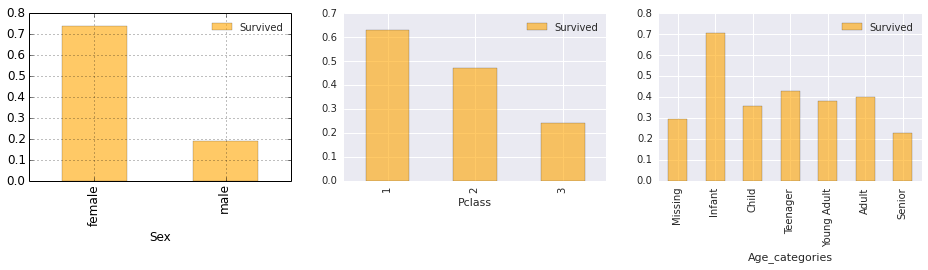

In [9]:
fig = plt.figure(figsize=(16, 3))

ax = fig.add_subplot(1,3,1)
plot_pivot("Sex", ax)

ax = fig.add_subplot(1,3,2)
plot_pivot("Pclass", ax)

ax = fig.add_subplot(1,3,3)
plot_pivot("Age_categories", ax)

As we expected, based the Birkenhead Drill, Women and Children were given priority over the rest of the passengers. At the same time, passengers with a higher status, as inferred from the class they were traveling in, also had a higher survivability rate.

#### A bit of Feature Pre-processing (One Hot Encoding) for training our first model.

A problem with label encoding is that it assumes higher the categorical value, better the category. For example, PClass certainly has some sort of ordered relationship, but it is not the same as the relationship between the numbers 1, 2, and 3. Pclass 2 isn't worth double what class 1 is.

To deal with this problem, we use [one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). We perform a "binarization" of the category and thus are able to include it in our model.

In [10]:
def one_hot_encode(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1),dummies],axis=1)
    return df

In [11]:
cols = ["Pclass", "Sex", "Age_categories"]

for col in cols:
    train = one_hot_encode(train,col)
    holdout = one_hot_encode(holdout,col)

## First Model: Logistic Regression (aka The Bread and Butter)

Now that our important features have been pre-processed, we are ready to train a first model. The first model we will use is called Logistic Regression, which is often the first model you will train when performing classification.

In [12]:
from sklearn.linear_model import LogisticRegression

ignore_columns = ['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

lr = LogisticRegression()
lr.fit(train.drop(ignore_columns, axis =1), train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

First attempt: Complete!  The next step is to find out how accurate our model is, by making predictions.

We split our train dataframe into two to avoid **[overfitting](https://en.wikipedia.org/wiki/Overfitting):**
80% of the observations will make the train set and the remaining 20% will make the test set. Note that we cannot use the holdout dataset for this purpose, as it does not contain a target (Survived?) column. 

In [13]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train.drop(ignore_columns, axis =1), train.Survived, test_size = 0.2)

There are a number of ways to measure the accuracy of machine learning models. In this case, the evaluation section for the Titanic competition on Kaggle tells us that our score calculated as "the percentage of passengers correctly predicted". This is by far the most common form of [accuracy](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models) for binary classification.

In [14]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

accuracy = accuracy_score(test_y, predictions)

print('Model Accuracy: {:.2%}'.format(accuracy))

Model Accuracy: 83.80%


#### Measuring Model Accuracy (Cross Validation)

The LR model has an accuracy score of 79.3% when tested against **ONLY** the 20% test set. The problem with machine learning models is that you won’t get to know how well a model performs until you test its performance on an independent data set (the data set which was not used for training the machine learning model). To give us a better understanding of the real performance of our model, we can use a technique called cross validation to train and test our model on different splits of our data.

The most common form of **cross validation** is called [k-fold cross validation](https://magoosh.com/data-science/k-fold-cross-validation/). Here, we split our data in k groups, train on k-1 and test on the remaining one. Repeat for all of the possible splits and then average the scoring metric of all the iterations.

In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(lr, train.drop(ignore_columns, axis =1), train.Survived, cv= 10)
accuracy = np.mean(scores)
print(scores)

print('Model Accuracy: {:.2%}'.format(accuracy))

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
Model Accuracy: 80.25%


The average accuracy score was 80.25%, not too different from the 81.0% we got from the simple train/test split. Keep in mind that this might not always be the case. It's a good practice to use cross validation as a way to have an accuracy score that better represents the model.

There are many things we can do to improve the accuracy of our model. 

**Improving the features:**<br/>
*Feature Engineering*: Create new features from the existing data (Binning, Extracting data from text, Date to time frame transformation).<br/>
*Feature Selection*: Select the most relevant features to reduce noise and overfitting (Reduce colinearity, Select features highly correlated to the target, Remove low variance features).<br/>

**Improving the model:**<br/>
*Model Selection*: Try a variety of models to improve performance.<br/>
*Hyperparameter Optimization*: Optimize the settings within each particular machine learning model.

## Feature Preparation, Selection and Engineering

There are a number of features we haven't yet utilized. Let's explore them!

In [16]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


SibSp, Parch and Fare are standard numeric columns with no missing values. Cabin has 687 missing values, and the ones that are not are mostly unique. Let's put a pin on that one for now. Embarked looks to be a standard categorical column with 3 unique values, much like PClass. There are two **missing values**.

### Dealing with missing data

We can deal with missing data in a couple of ways:<br/>
**Remove** rows containing missing values for specific columns<br/>
Pro: Rows containing missing values are removed, leaving only clean data for modeling.<br/>
Con: Entire observations from the training set are removed, which can reduce overall prediction accuracy.

**Impute** (or replace) missing values using a descriptive statistic from the column (mean, mode)<br/>
Pro: Missing values are replaced with potentially similar estimates, preserving the rest of the observation in the model.<br/>
Con: Depending on the approach, we may be adding noisy data for the model to learn

For this case, we can easily fill these two missing values with the most common value, "S" which occurs 644 times.

In [17]:
train.Embarked = train.Embarked.fillna("S")
holdout.Embarked = holdout.Embarked.fillna("S")

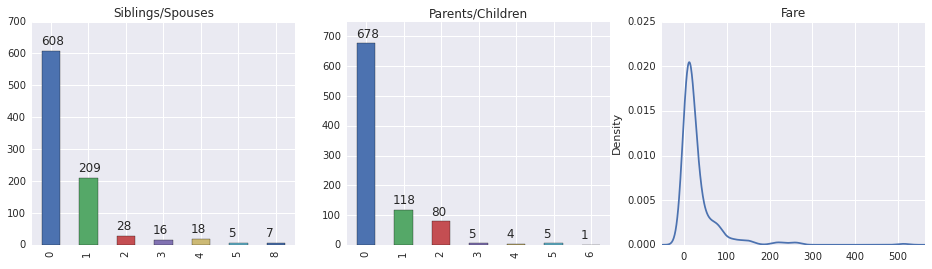

In [18]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(1,3,1)
sibsp_counts = train.SibSp.value_counts().sort_index()
sibsp_counts.plot.bar()
ax.set_title("Siblings/Spouses")
for x, y in enumerate(sibsp_counts):
    ax.text(x - 0.25, y + 20 , str(y))

ax = fig.add_subplot(1,3,2)
parch_counts = train.Parch.value_counts().sort_index()
parch_counts.plot.bar(ylim=(0,750))
ax.set_title("Parents/Children")
for x, y in enumerate(parch_counts):
    ax.text(x - 0.25, y + 20 , str(y))
    
ax = fig.add_subplot(1,3,3)
train.Fare.plot.kde(xlim = (-50,train.Fare.max()+50))
ax.set_title("Fare")

### Rescaling

Looking at our numeric columns, we can see a big difference between the range of each. SibSp and Parch have values between 0-8, but Fare is on a dramatically **different scale**, with values ranging from 0-512. Also, there are **outliers** in all three distributions. These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators. In order to make sure these values are equally weighted within our model, we'll need to [rescale](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) the data.

The link above provides a good summarization of different scaling methods and their shortcomings.

In [ ]:
from sklearn.preprocessing import minmax_scale

#There are some missing values for Fare in the Holdout dataset
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

#One hot encode Embarked
train = one_hot_encode(train, "Embarked")
holdout = one_hot_encode(holdout, "Embarked")

#Scale the rest of the columns
old_cols = ["SibSp", "Parch", "Fare"]
scaled_cols = ["SibSp_scaled", "Parch_scaled", "Fare_scaled"]

for old, new in zip(old_cols, scaled_cols):
    train[new] = minmax_scale(train[old])
    holdout[new] = minmax_scale(holdout[old])

### Feature Selection

In order to select the best-performing features, we need a way to measure which features are relevant to the outcome. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature. Other methods include dropping features with low variance and selecting features with high correlation to the target.

In a regression model, if everything is a very similar magnitude, a larger coefficient, either positive or negative, means larger effect, all things being equal.However, if data isn't normalized, the magnitude of the coefficients don't mean anything (without context). For instance, you could get different coefficients by changing the units of measure to be larger or smaller.

In this case, we're doing a logisitc regresion, in which the coefficients are [odd-ratios](https://stats.idre.ucla.edu/stata/faq/how-do-i-interpret-odds-ratios-in-logistic-regression/).

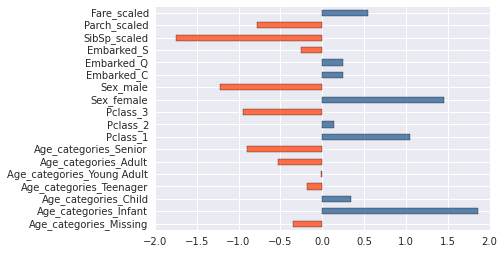

In [20]:
columns = ['Age_categories_Missing', 'Age_categories_Infant','Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult','Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S','SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns],train.Survived)
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index = columns)
positive = pd.Series(coefficients[0] > 0)
positive = positive.map({True: (0.2, 0.4, 0.6, 0.8), False: (1.0, 0.3, 0.1, 0.8)})
feature_importance.plot.barh(color=positive)

Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value, since a better prediction of either death or survival is a good prediction on a mutually exclusive outcome. 

Note: The sign differences can however, in the case of categorical features, help us understand that an infant has a higher chance of surviving (positive large coefficient), as opposed to a male passenger (second largest negative coefficient).

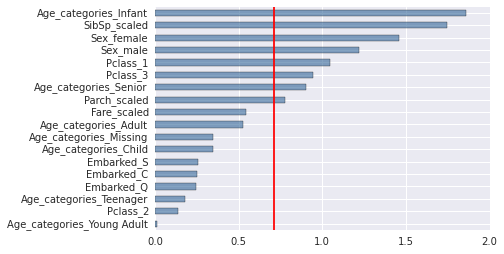

In [21]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh(color=(0.2, 0.4, 0.6, 0.6))
plt.axvline(c="red",x= ordered_feature_importance.mean())
plt.show()

Let's use the features that had above average coefficients.

In [22]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male','Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv =10)
accuracy = scores.mean()

print('Model Accuracy: {:.2%}'.format(accuracy))

Model Accuracy: 81.48%


The cross validation score of 81.48% is slightly higher than the cross validation score for the Logistic Regression Model (80.25%)

What can we do to improve this even further?

### Feature Engineering

A lot of the gains in accuracy in machine learning come from Feature Engineering. Feature engineering is the practice of creating new features from your existing data.

One common way to engineer a feature is using a technique called binning. [Binning](https://en.wikipedia.org/wiki/Data_binning) is when you take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable. Just like we did for the Age feature when doing the Exploratory Data Analysis.

This can be useful when there are patterns in the data that are non-linear and you're using a linear model (like logistic regression).  (How?)

Let's look at the histogram of the Fare column for passengers who died and survived, and see if there are patterns that we can use when creating our bins.

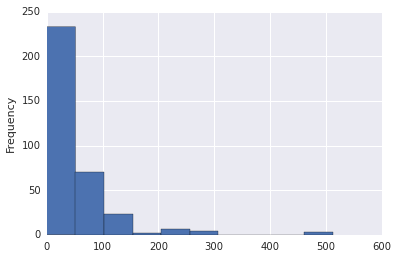

In [23]:
train.Fare[train.Survived == 1].plot.hist()

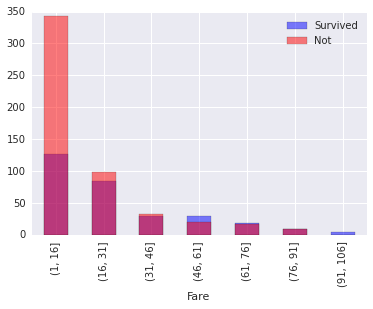

In [24]:
survived = pd.cut(train.Fare[train.Survived == 1], range(1,120, 15)).value_counts()
survived.plot.bar(alpha = 0.5, color = "blue", label = "Survived")

not_survived = pd.cut(train.Fare[train.Survived == 0], range(1,120, 15)).value_counts()
not_survived.plot.bar(alpha = 0.5, color = "red", label = "Not")

plt.legend()
plt.xlabel("Fare")

Roughly 60% of the people with the cheapest fare didn't make it our alive. This trend continues, although to a lesser extent, until we reach a fare of 46, where survivability is prettymuch a coin toss. After that, Fares of 90+ seem to have a 100% survival rate. Let's apply this knowledge to transform our Fare column.

In [25]:
cuts= [0,15,50,100,1000]
labels = ["0-15", "15-50", "50-100", "100+"]

train = binning(train, "Fare", cuts,labels)
holdout = binning(holdout,"Fare", cuts, labels)

train = one_hot_encode(train, "Fare_categories")
holdout = one_hot_encode(holdout, "Fare_categories")

Another way to engineer features is by extracting data from text columns. Name and Cabin columns weren't useful by themselves, since they are mostly unique values, but is there useful information that can be extracted from them?

The format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful.

Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess'. By spending some time researching the different titles, we can categorize these into six types:

- Mr
- Mrs
- Miss
- Officer
- Nobility

We can use the Series.str.extract method and [Regex Fu](https://blog.codinghorror.com/regular-expressions-now-you-have-two-problems/) to extract the title from each name and then use the Series.map() method and a predefined dictionary to simplify the titles.

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


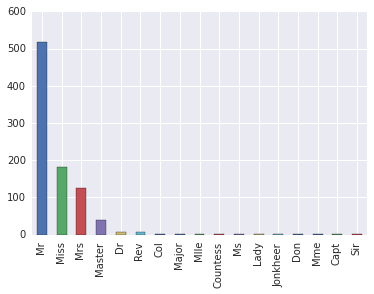

In [26]:
titles= train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
print(titles.unique())
titles.value_counts().plot.bar()

In [27]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Nobility",
    "Don":         "Nobility",
    "Sir" :        "Nobility",
    "Countess":    "Nobility",
    "Dona":        "Nobility",
    "Lady" :       "Nobility"
}

Let's perform the usual pre-processing for Titles (categorical)

In [28]:
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train = one_hot_encode(train, "Title")
holdout = one_hot_encode(holdout, "Title")

train = train.drop("Name", axis=1)
holdout = holdout.drop("Name", axis=1)

...and for Cabin Type

In [29]:
train["Cabin_type"] = train.Cabin.str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout.Cabin.str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

train = train.drop("Cabin", axis=1)
holdout = holdout.drop("Cabin", axis=1)

train = one_hot_encode(train, "Cabin_type")
holdout = one_hot_encode(holdout, "Cabin_type")

### Collinearity

We now have 34 possible feature columns we can use to train our model. One thing to be aware of as you start to add more features is a concept called **collinearity**. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that your model will overfit - you may get great results on your test data set, but then the model performs worse on unseen data (like the holdout set).

One easy way to understand collinearity is with a simple binary variable like the Sex column in our dataset. Every passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'. This is called the [dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html). The easy solution is to choose one column to drop any time you make dummy columns.

Collinearity can happen in other places, too. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap. 

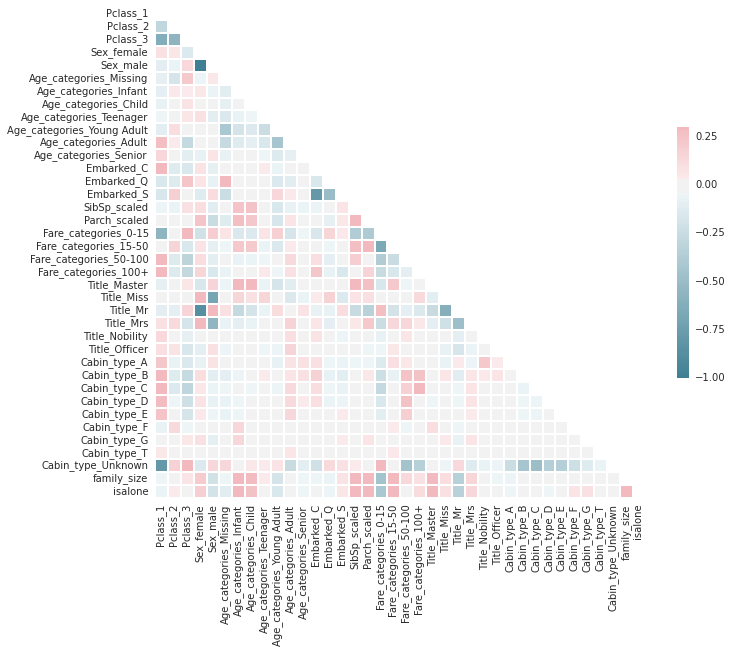

In [51]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

ignore_columns = ["PassengerId", "Survived", "SibSp","Parch","Fare_scaled", "Ticket"]

plot_correlation_heatmap(train.drop(ignore_columns, axis=1))

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more granular.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

- Pclass_2
- Age_categories_Teenager
- Fare_categories_15-50
- Title_Master
- Cabin_type_A

### (Engineered) Feature Selection (with RFECV)

In an earlier step, we manually used the **logit coefficients** to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation.

The RFECV class starts by training a model using all of your features and scores it using **cross validation**. It then uses the **logit coefficients** to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

Like the LogisticRegression class, RFECV must first be instantiated and then fit. The first parameter when creating the RFECV object must be an estimator, and we need to use the cv parameter to specific the number of folds for cross-validation.

In [31]:
from sklearn.feature_selection import RFECV

ignore_columns = ["PassengerId", "Ticket", "Survived", "SibSp","Parch","Fare_scaled", "Pclass_2",
                  "Age_categories_Teenager", "Fare_categories_15-50", "Title_Master","Cabin_type_A",
                 "Sex_female","Sex_male"]

all_X = train.drop(ignore_columns, axis=1)
all_y = train.Survived

lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)

optimized_columns = all_X.columns[selector.support_]
print(optimized_columns)

Index([u'SibSp_scaled', u'Title_Mr', u'Title_Officer', u'Cabin_type_Unknown'], dtype='object')


In [32]:
all_X = train[optimized_columns]
all_y = train.Survived

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)

accuracy = scores.mean()
print('Model Accuracy: {:.2%}'.format(accuracy))

Model Accuracy: 82.27%


This four-feature model scores 82.27%, a modest improvement compared to the 81.48% from our earlier model

## Model Selection and Tuning

We worked to optimize our predictions by creating and selecting the features used to train our model. The other half of the optimization puzzle is to optimize the model itself,  or more specifically, the algorithm used to train our model.

For starters, we're going to train our models using all the columns in the train dataframe. This will cause a small amount of overfitting due to collinearity, but having more features will allow us to more thoroughly compare algorithms.

We're going to train a logistic regression model using cross validation to get a baseline score.

In [33]:
all_X = train.drop(ignore_columns, axis=1)
all_y = train.Survived

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy_lr = scores.mean()
print('Model Accuracy: {:.2%}'.format(accuracy_lr))

Model Accuracy: 81.60%


Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data.

Two popular and simple algorithms are [k-nearest neighbors](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/) and [random forest](https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd).

### K-nearest neighbors

The k-nearest neighbors algorithm finds the k observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction.

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
scores = cross_val_score(knn, all_X, all_y, cv =10)
accuracy_knn = scores.mean()
print('Model Accuracy: {:.2%}'.format(accuracy_knn))

Model Accuracy: 80.15%


Besides pure model selection, we can vary the settings of each model, for instance the value of k in our k-nearest neighbors model. This is called **hyperparameter optimization**.

In [35]:
knn_scores = []
#steps of 2 two prevent ties.
for i in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, all_X, all_y, cv = 10)
    knn_scores.append(scores.mean())

Model Accuracy: 81.71%  Best K:35 


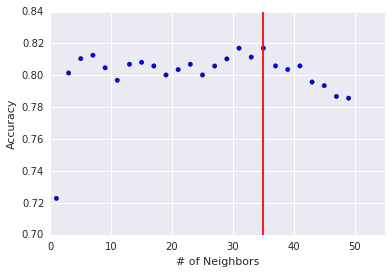

In [36]:
sns.set()
plt.scatter(range(1,50,2), knn_scores)
plt.xlim(0,55)
plt.ylabel("Accuracy")
plt.xlabel("# of Neighbors")
accuracy_knn = max(knn_scores)
best_k = knn_scores.index(accuracy_knn)*2+1
plt.axvline(c="red",x= best_k)
print('Model Accuracy: {:.2%}  Best K:{} '.format(accuracy_knn, best_k))

Looking at our plot from the previous screen we can see that a k value of 35 gave us our best score of 81.71%, slightly better than our Logistic Regression.

### Hyperparameter Tuning (GridSearchCV)

In our previous attempt we only tuned the number of neighbors parameter of knn. Let's use the Grid Search Library to explore several hyperparameters at the same time.

In [37]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,40,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid = hyperparameters,cv = 10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print('Model Accuracy: {:.2%}'.format(grid.best_score_))

{'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}
Model Accuracy: 81.71%


Not a lot of improvement. Let's try another algorithm called Random Forest.

### Random Forest

Random Forest is a specific type of decision tree algorithm. Decision tree algorithms attempt to build the most efficient decision tree based on the training data, and then use that tree to make future predictions.

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y,cv=10)
accurcy_clf = scores.mean()
print('Model Accuracy: {:.2%}'.format(accurcy_clf))

Model Accuracy: 82.05%


In [39]:
hyperparameters = {"criterion":["entropy" , "gini"],
"max_depth" : [5,10],
"max_features": ["log2","sqrt"],
"min_samples_leaf":  [1,5],
"min_samples_split": [3,5],
"n_estimators": [6,9]}

grid = GridSearchCV(clf,param_grid = hyperparameters,cv = 10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print('Model Accuracy: {:.2%}'.format(grid.best_score_))

{'min_samples_leaf': 1, 'n_estimators': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10}
Model Accuracy: 82.94%


Random Forest gives us the best Accuracy out of the three tuned models we tried. However, this measure is still based on the training set. To get a better idea of how well our models generalize, we can submit our predictions on the holdout dataset to Kaggle and see if indeed Random Forest was the best one for this dataset.

As a final, comprehensive example, let's meddle a little bit more with the *SibSp* and *Parch* columns. Since these column give us information on a passenger's relatives, we might be able to combine them into just one feature.

## EDA

In [40]:
train[["SibSp","Parch"]].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


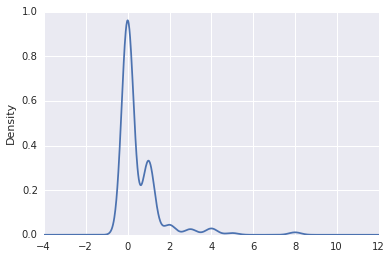

In [41]:
print train.SibSp.value_counts()
train.SibSp.plot.kde()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


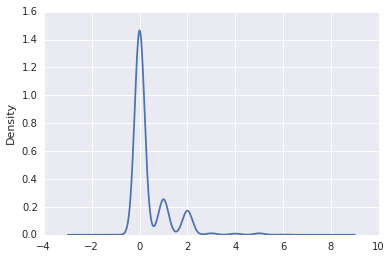

In [42]:
print train.Parch.value_counts()
train.Parch.plot.kde()

The distribution of values in both columns is skewed right, with the majority of values being zero.

Let's see how these features are related to survival.

In [43]:
np.round(pd.pivot_table(train, values='Survived', index='SibSp',  columns='Parch'),2)
#.apply(round,args=[2])

Parch,0,1,2,3,4,5,6
SibSp,,,,,,,
0,0.30,0.66,0.72,1.00,0.0,0.00,NaN
1,0.52,0.60,0.63,0.33,0.0,0.33,0.0
2,0.25,0.86,0.50,1.00,NaN,NaN,NaN
3,1.00,0.00,0.29,NaN,NaN,NaN,NaN
4,NaN,0.00,0.33,NaN,NaN,NaN,NaN
5,NaN,NaN,0.00,NaN,NaN,NaN,NaN
8,NaN,NaN,0.00,NaN,NaN,NaN,NaN


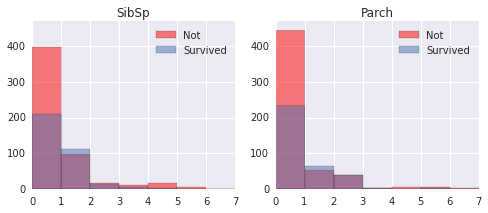

In [44]:
fig = plt.figure(figsize=(8, 3))

survived = train[train.Survived == 1]
deceased = train[train.Survived == 0]

ax = fig.add_subplot(1,2,1)
ax.set_title("SibSp")
ax.set_ylim(0,470)
plt.hist(deceased.SibSp, alpha=0.5, color = "red", bins = range(8), label = "Not")
plt.hist(np.array(survived.SibSp), alpha=0.5, bins = range(8), label= "Survived")
plt.legend()

ax = fig.add_subplot(1,2,2)
ax.set_title("Parch")
ax.set_ylim(0,470)
plt.hist(deceased.Parch, alpha=0.5, color = "red", bins = range(8), label = "Not")
plt.hist(np.array(survived.Parch), alpha=0.5, bins = range(8), label= "Survived")
plt.legend()

The trend seems to be that you are more likely to die if you traveled alone *or* with a lot of family members.

## Feature Engineering

In [45]:
train["family_size"] = train.SibSp + train.Parch
train.pivot_table(index='family_size',values="Survived")

,Survived
family_size,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


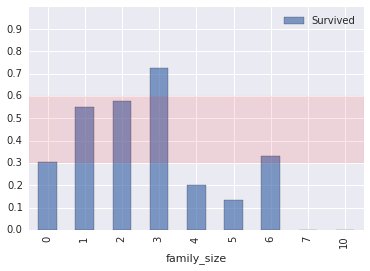

In [46]:
pivot = train.pivot_table(index="family_size",values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1), alpha = 0.7)
plt.axhspan(.3, .6, alpha=0.1, color='red')
plt.show()

Looking at the survival rates of the the combined family members, we can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

Idea for a new feature: Was the passenger alone? This can be represented as a binary feature.

In [47]:
def is_alone(df):
    df["isalone"] = df["family_size"]  > 1
    return df

In [48]:
train = is_alone(train)
holdout["family_size"] = holdout.SibSp + holdout.Parch
holdout = is_alone(holdout)

## Feature Selection

In [56]:
def select_features(df, ignore_columns):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    X = df.drop(ignore_columns,axis=1)
    y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(X,y)
    
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

ignore_columns = ["PassengerId", "Survived", "SibSp","Parch","Fare_scaled", "Pclass_2",
                  "Age_categories_Teenager", "Fare_categories_15-50", "Title_Master","Cabin_type_A",
                 "Sex_female","Sex_male", "SibSp", "Parch"]

cols = select_features(train, ignore_columns)

Best Columns 
------------
['Title_Miss', 'Title_Mr', 'family_size']



## Model Selection / Hyperparameter Tuning

In [57]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.806958473625
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.81593714927
Best Parameters: {'n_neighbors': 13, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}

RandomForestClassifier
----------------------
Best Score: 0.817059483726
Best Parameters: {'min_samples_leaf': 5, 'n_estimators': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5}



Jesus, take the wheel

In [58]:
ignore_columns = ["PassengerId", "Survived"]

cols = select_features(train, ignore_columns)
result = select_model(train,cols)

Best Columns 
------------
['Sex_female', 'Sex_male', 'Fare_scaled', 'Title_Mr', 'family_size']

LogisticRegression
------------------
Best Score: 0.796857463524
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.838383838384
Best Parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1}

RandomForestClassifier
----------------------
Best Score: 0.836139169473
Best Parameters: {'min_samples_leaf': 5, 'n_estimators': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 10}

